# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

Now the following is the solution

## SOLUTION

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
from mathutils import geometry as pygeo
from mathutils import Vector
import json
from utils import *
import cv2 as cv
import glob
import regex as re
from PIL import Image
from IPython.display import Image as IPImage, display
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


### Variable initialisation


This section will calibrate the cameras constants for later stereovision

In [2]:
# Définir les critères d'arrêt pour l'algorithme de recherche des coins
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Ce critère signifie :
# - TERM_CRITERIA_EPS : Arrêter quand la précision est suffisante
# - TERM_CRITERIA_MAX_ITER : Ou arrêter après 30 itérations
# - 0.001 est le seuil de précision demandé

# Préparer les points 3D du damier, avec z=0 (surface plane)
objp = np.zeros((7 * 7, 3), np.float32)  # Initialisation d'un tableau 7x7x3 rempli de zéros
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)  # Génère les coordonnées x, y pour chaque coin

# Listes pour stocker les points 3D (réels) et 2D (image)
objpoints = []  # Points 3D dans l'espace réel
imgpoints = []  # Points 2D projetés sur l'image

# Charger les images des damiers pour calibrer les caméras
for fname in glob.glob('chessboards/c4*.png'):  # Parcourt les images correspondant au motif
    img = cv.imread(fname)  # Charger l'image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Convertir l'image en niveaux de gris pour simplifier le traitement
    
    # Trouver les coins du damier (7x7 intersections attendues)
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None)
    
    if ret:  # Si les coins sont trouvés
        objpoints.append(objp)  # Ajouter les points 3D
        imgpoints.append(corners)  # Ajouter les coins détectés (points 2D)

# Calibrer la caméra une fois que nous avons les points 3D et 2D
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

# Résultats de la calibration :
# - ret : Indique si la calibration a réussi
# - mtx : Matrice intrinsèque de la caméra
# - dist : Coefficients de distorsion (non utilisés ici)
# - rvecs : Vecteurs de rotation (par image)
# - tvecs : Vecteurs de translation (par image)

# Convertir les vecteurs de rotation (rvecs) en matrices de rotation (3x3)
rmatRight = cv.Rodrigues(rvecs[0])[0]  # Image de droite
rmatLeft = cv.Rodrigues(rvecs[1])[0]  # Image de gauche

# Construire les matrices de projection en ajoutant les vecteurs de translation
rotMatRight = np.concatenate((rmatRight, tvecs[0]), axis=1)  # (3x4)
rotMatLeft = np.concatenate((rmatLeft, tvecs[1]), axis=1)  # (3x4)

# Calculer les matrices de projection des caméras (matrice intrinsèque x matrice rotation-translation)
camLeft = mtx @ rotMatLeft  # Projection caméra gauche
camRight = mtx @ rotMatRight  # Projection caméra droite

# Calculer les centres des caméras dans le repère du monde (en coordonnées homogènes 4x1)
camWorldCenterLeft = np.linalg.inv(
    np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)
) @ np.transpose([[0, 0, 0, 1]])

camWorldCenterRight = np.linalg.inv(
    np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)
) @ np.transpose([[0, 0, 0, 1]])

print("Matrice de projection de la caméra gauche :")
print(camLeft)
print("\nMatrice de projection de la caméra droite :")
print(camRight)
# Résumé des matrices calculées :
# - camLeft / camRight : Matrices de projection des caméras
# - camWorldCenterLeft / camWorldCenterRight : Positions des caméras dans le repère du monde

Matrice de projection de la caméra gauche :
[[ 1.86636060e+03 -1.93198743e+02  1.39223860e+03  1.53376954e+04]
 [ 1.69166053e+01  2.10172547e+03  6.38302891e+02  3.60734361e+03]
 [-2.18282371e-01 -3.89329080e-02  9.75108730e-01  2.09881592e+01]]

Matrice de projection de la caméra droite :
[[ 2.26101702e+03 -2.18772612e+02  5.46714308e+02  1.43930805e+04]
 [ 2.73604035e+02  2.08265685e+03  6.42376800e+02  3.02966777e+03]
 [ 1.79659903e-01 -6.84945954e-02  9.81341332e-01  2.00986516e+01]]


### Plot les cameras dans l'espace

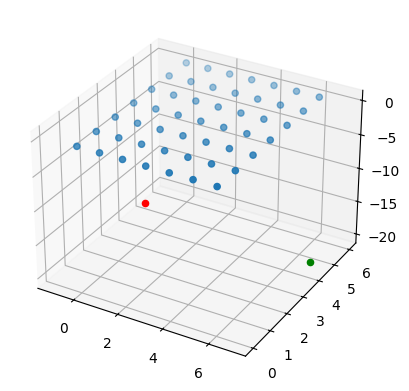

In [3]:
plotDotWorld(camWorldCenterLeft,camWorldCenterRight,objp)

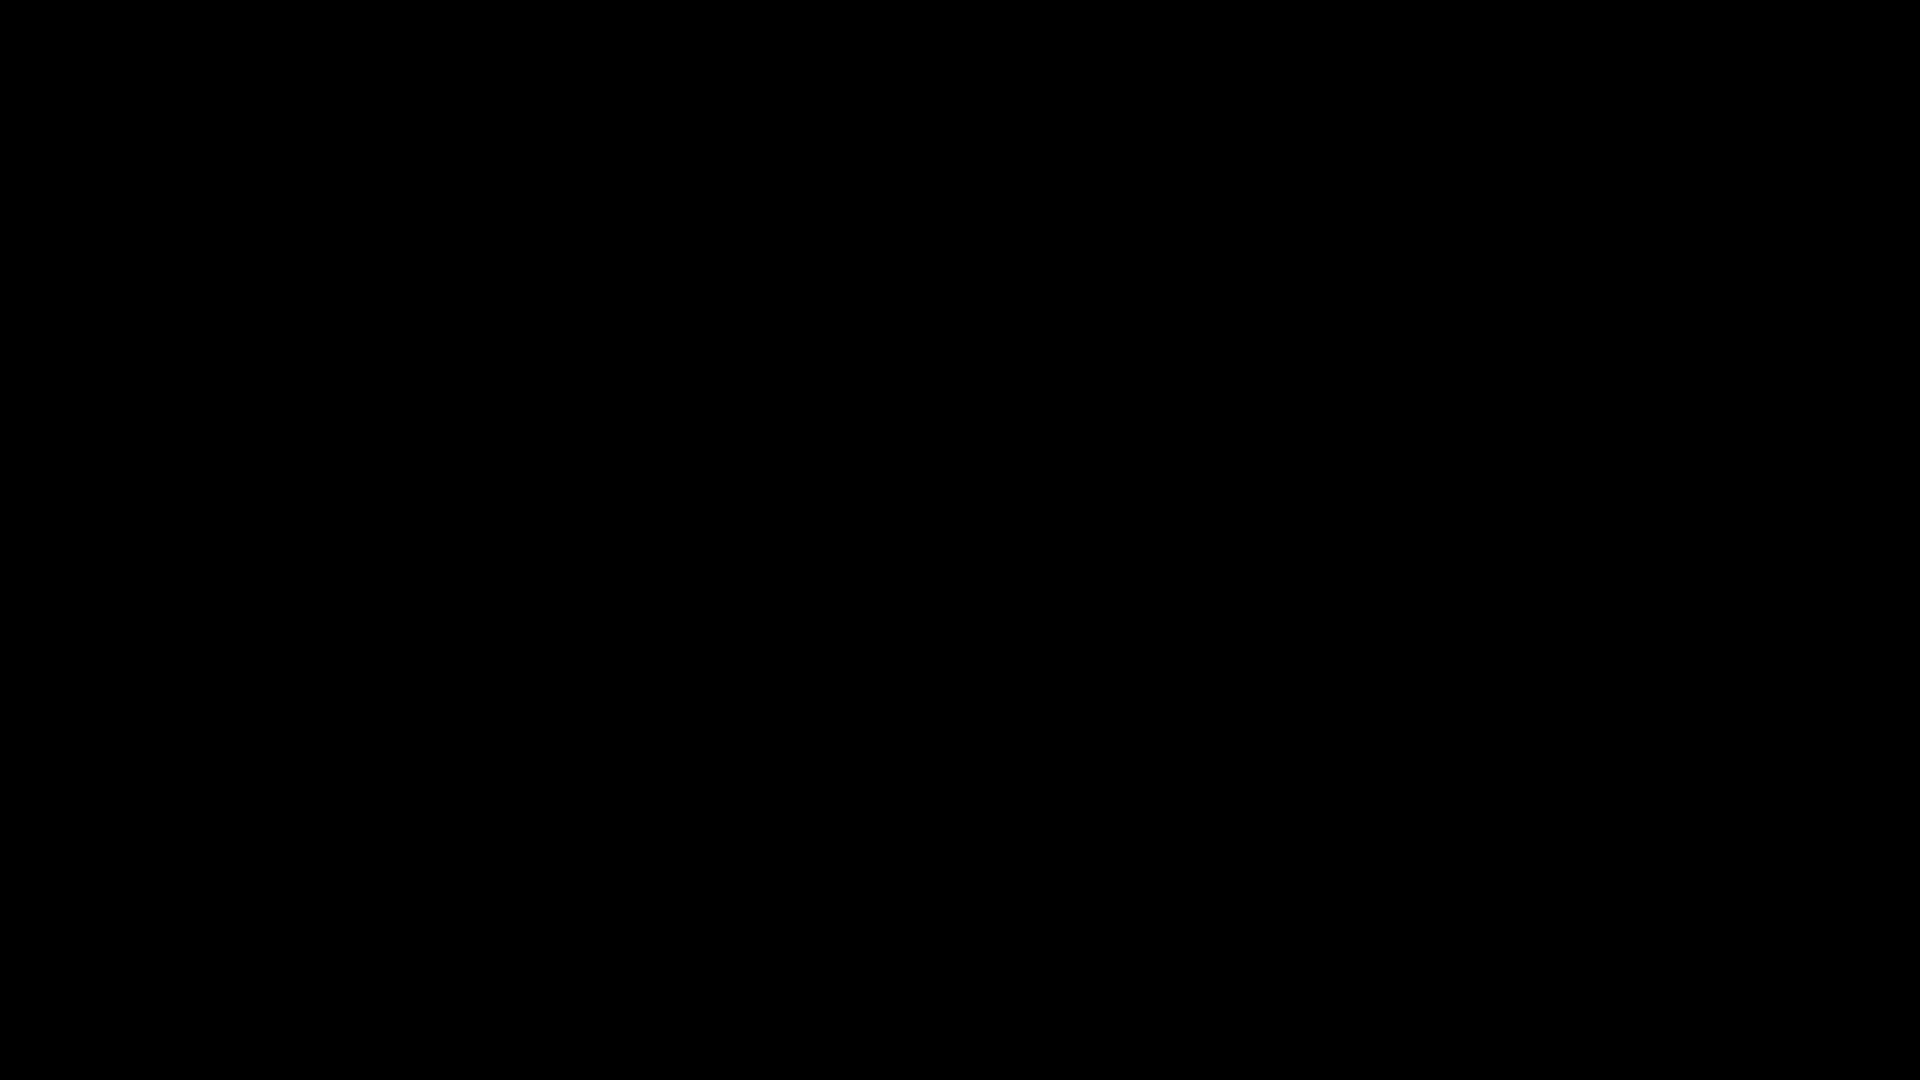

In [4]:
# Liste pour stocker les frames du GIF
frames = []

# Parcourir toutes les images du dossier spécifié (par exemple, "scanRight")
image_files = glob.glob("scanRight/*.png")  # Remplacez par votre chemin si nécessaire

for img_file in sorted(image_files):  # Trier pour garder un ordre cohérent
    # Charger l'image
    img = cv.imread(img_file)  # Charge chaque image dans une variable
    
    # Appliquer un seuil pour extraire la ligne
    ret, mask = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)
    
    # Convertir le masque en format compatible avec PIL (RVB)
    mask_rgb = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    pil_image = Image.fromarray(mask_rgb)  # Convertir l'image en objet PIL
    
    # Ajouter l'image traitée à la liste des frames
    frames.append(pil_image)

# Générer le GIF
output_gif_path = "output.gif"  # Nom du fichier GIF généré
frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],  # Ajouter toutes les frames sauf la première
    duration=200,  # Durée de chaque frame en millisecondes
    loop=0  # 0 = boucle infinie
)

# Afficher le GIF dans Jupyter
display(IPImage(output_gif_path))

# Computing the Fundamental Matrix and Epipolar Geometry

## 1. Calculating the Fundamental Matrix

In this section, we compute the **Fundamental Matrix** (`Fondamental`), which defines the relationship between corresponding points in the left and right camera views.

### Code Explanation:
```python
Fondamental = matFondamental(camRight, camWorldCenterLeft, camLeft)


In [5]:
# Compute the Fundamental Matrix
Fondamental = matFondamental(camRight, camWorldCenterLeft, camLeft)
# This creates the fundamental matrix, which relates points in the left camera's view 
# to corresponding epipolar lines in the right camera's view.
# Inputs:
# - camRight: The projection matrix of the right camera (3x4).
# - camWorldCenterLeft: The position of the left camera in world coordinates (4x1 homogeneous).
# - camLeft: The projection matrix of the left camera (3x4).
# Process:
# The function combines the intrinsic and extrinsic camera parameters, along with
# the pseudo-inverse of the right camera matrix, to calculate a 3x3 fundamental matrix.
# Output:
# - Fondamental: Encodes the epipolar geometry between the two cameras.

# Compute the epipolar geometry for images in the 'scanLeft/' folder
epl = findEpilines('scanLeft/', Fondamental)
# This calculates the epilines for each image in the sequence located in 'scanLeft/'.
# Inputs:
# - 'scanLeft/': The folder containing the input images, which are assumed to show a laser line.
# - Fondamental: The fundamental matrix, used to compute epilines for each point.
# Process:
# - For each image in the folder:
#   1. `getImgLine` isolates the red laser line in the image (removes other details).
#   2. It calculates the average X position of red pixels for each row (laser line points).
#   3. These points (`pointsLeft`) are transformed using the fundamental matrix
#      to compute the corresponding epipolar lines (`epilinesRight`) in the right image.
# - The epipolar lines and points are stored for later use.
# Output:
# - `epl`: A list of `[pointsLeft, epilinesRight]` for all images.


### Drawing the EPLs

GIF créé : output_1.gif


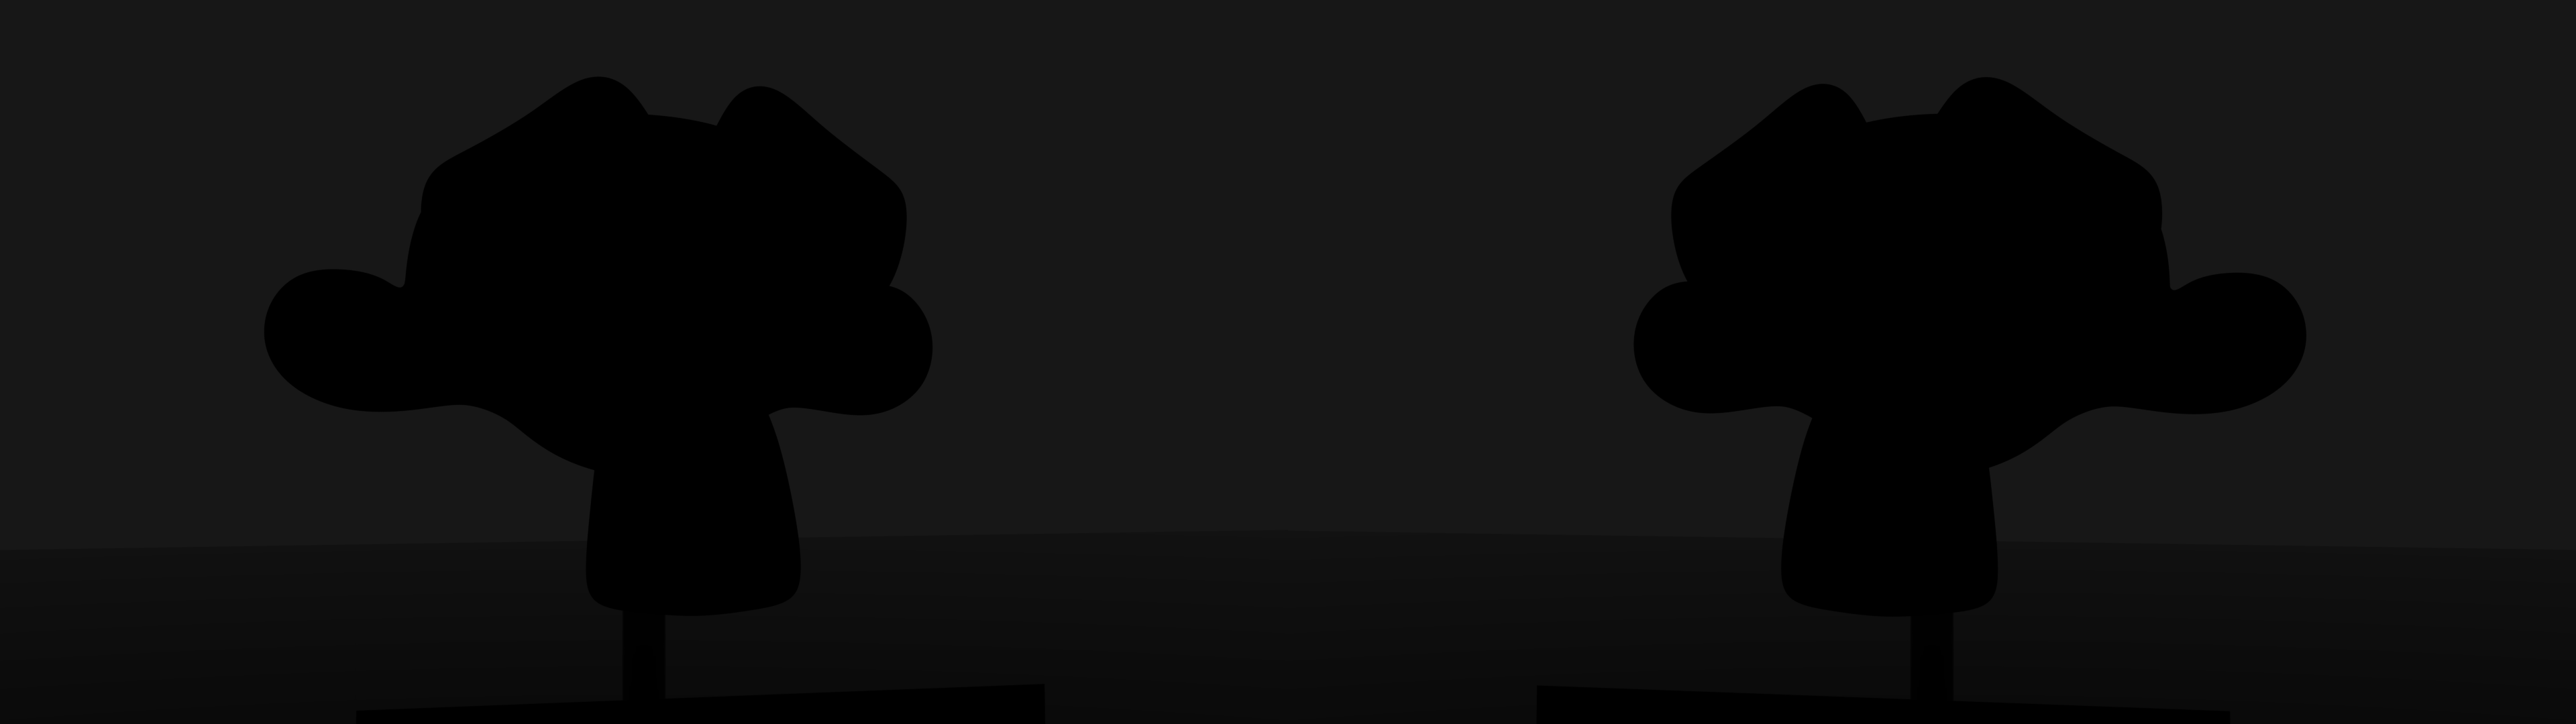

In [6]:

process_folder(
    left_folder='scanLeft',
    right_folder='scanRight',
    EplLeft=epl,  
    EplRight=epl, 
    output_gif_path='output_1.gif',
    duration=300
)

display(pythImage(filename='output_1.gif'))



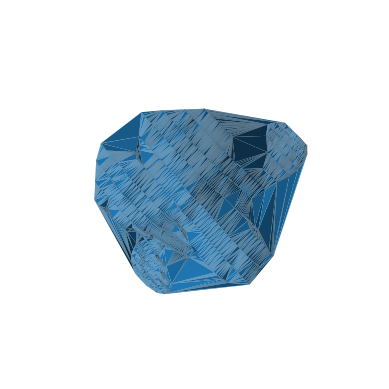

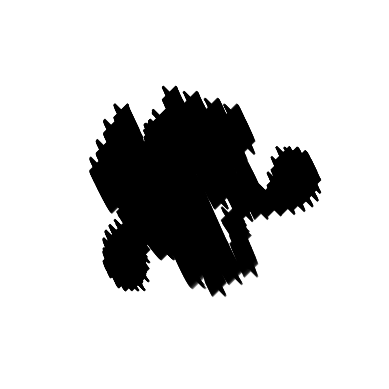

In [7]:
pointsRight = eplRedPoints('scanRight/scan',epl)
pointsLeft = eplRedPoints('scanLeft/',epl)

point = getObjectPoint(pointsRight,epl,camWorldCenterLeft,camWorldCenterRight,camLeft,camRight)
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)
